<a href="https://colab.research.google.com/github/MazonSzymon/modelowanie_cen_akcji_spolek/blob/main/Praca_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#  ***Modelowanie  cen  (zwrotów  ceny)  akcji  spółek:  Alior Bank, mBank, Dino Polska, CD Projekt  przy  użyciu  modeli szeregów czasowych ARMA, ARIMA*** 

---

#Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader as pdr 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
%load_ext google.colab.data_table




#Set up plot
from cycler import cycler
plt.style.use('ggplot')
plt.rc('axes', facecolor='white', edgecolor='black', grid = False, axisbelow = True)
plt.rc('grid',color='gray', linestyle='solid', linewidth=0.5)
plt.rc('patch', edgecolor='black')
plt.rc('legend', shadow=True, handlelength=1, fontsize=10, edgecolor = 'black', facecolor='white')

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [2]:
!git clone https://github.com/MazonSzymon/modelowanie_cen_akcji_spolek.git
import sys
sys.path.append('/content/modelowanie_cen_akcji_spolek/')

Cloning into 'modelowanie_cen_akcji_spolek'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


# Stooq data

>## Stocks company list




In [4]:
our_stocks = pd.DataFrame(np.array([
                                    ['WI20','wig20.pl'],
                                    ['Alior Bank','alr.pl'],
                                    ['CD Projekt', 'cdr.pl'],
                                    ['Dino Polska', 'dnp.pl'],
                                    ['mBank', 'mbk.pl']
]), columns = ['Full_name','Stoq_name'])



>## Download data and main DataFrame functions



In [5]:
def get_data(stock,start_date, end_date):
  stooq_data = pdr.get_data_stooq(stock['Stoq_name'], start = start_date, end = end_date).sort_index()
  stooq_data['Stock_name'] = stock['Full_name']
  df = stooq_data.copy()
  return df

In [6]:
def creat_WIG20_frame(start_date,end_date,stocks_list):
  WIG20 = pd.DataFrame()
  for i in range(len(stocks_list)):
    tmp = get_data(stocks_list.iloc[i],start_date,end_date)
    WIG20 = WIG20.append(tmp)
  return WIG20



>## Main DataFrame



>> ### Creat main DataFrame





In [7]:
start_date = dt.date(2020,1,1)
end_date = dt.date.today()
df = creat_WIG20_frame(start_date,end_date,our_stocks) #API, dont run many times!

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1105 entries, 2020-01-02 to 2020-11-13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1105 non-null   float64
 1   High        1105 non-null   float64
 2   Low         1105 non-null   float64
 3   Close       1105 non-null   float64
 4   Volume      1105 non-null   int64  
 5   Stock_name  1105 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 60.4+ KB


In [9]:
df.drop( columns= ['Open','High','Low','Volume'],inplace = True)
df['Stock_name'] = df['Stock_name'].astype('category')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1105 entries, 2020-01-02 to 2020-11-13
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Close       1105 non-null   float64 
 1   Stock_name  1105 non-null   category
dtypes: category(1), float64(1)
memory usage: 18.5 KB


>> ### Data Visualization

 



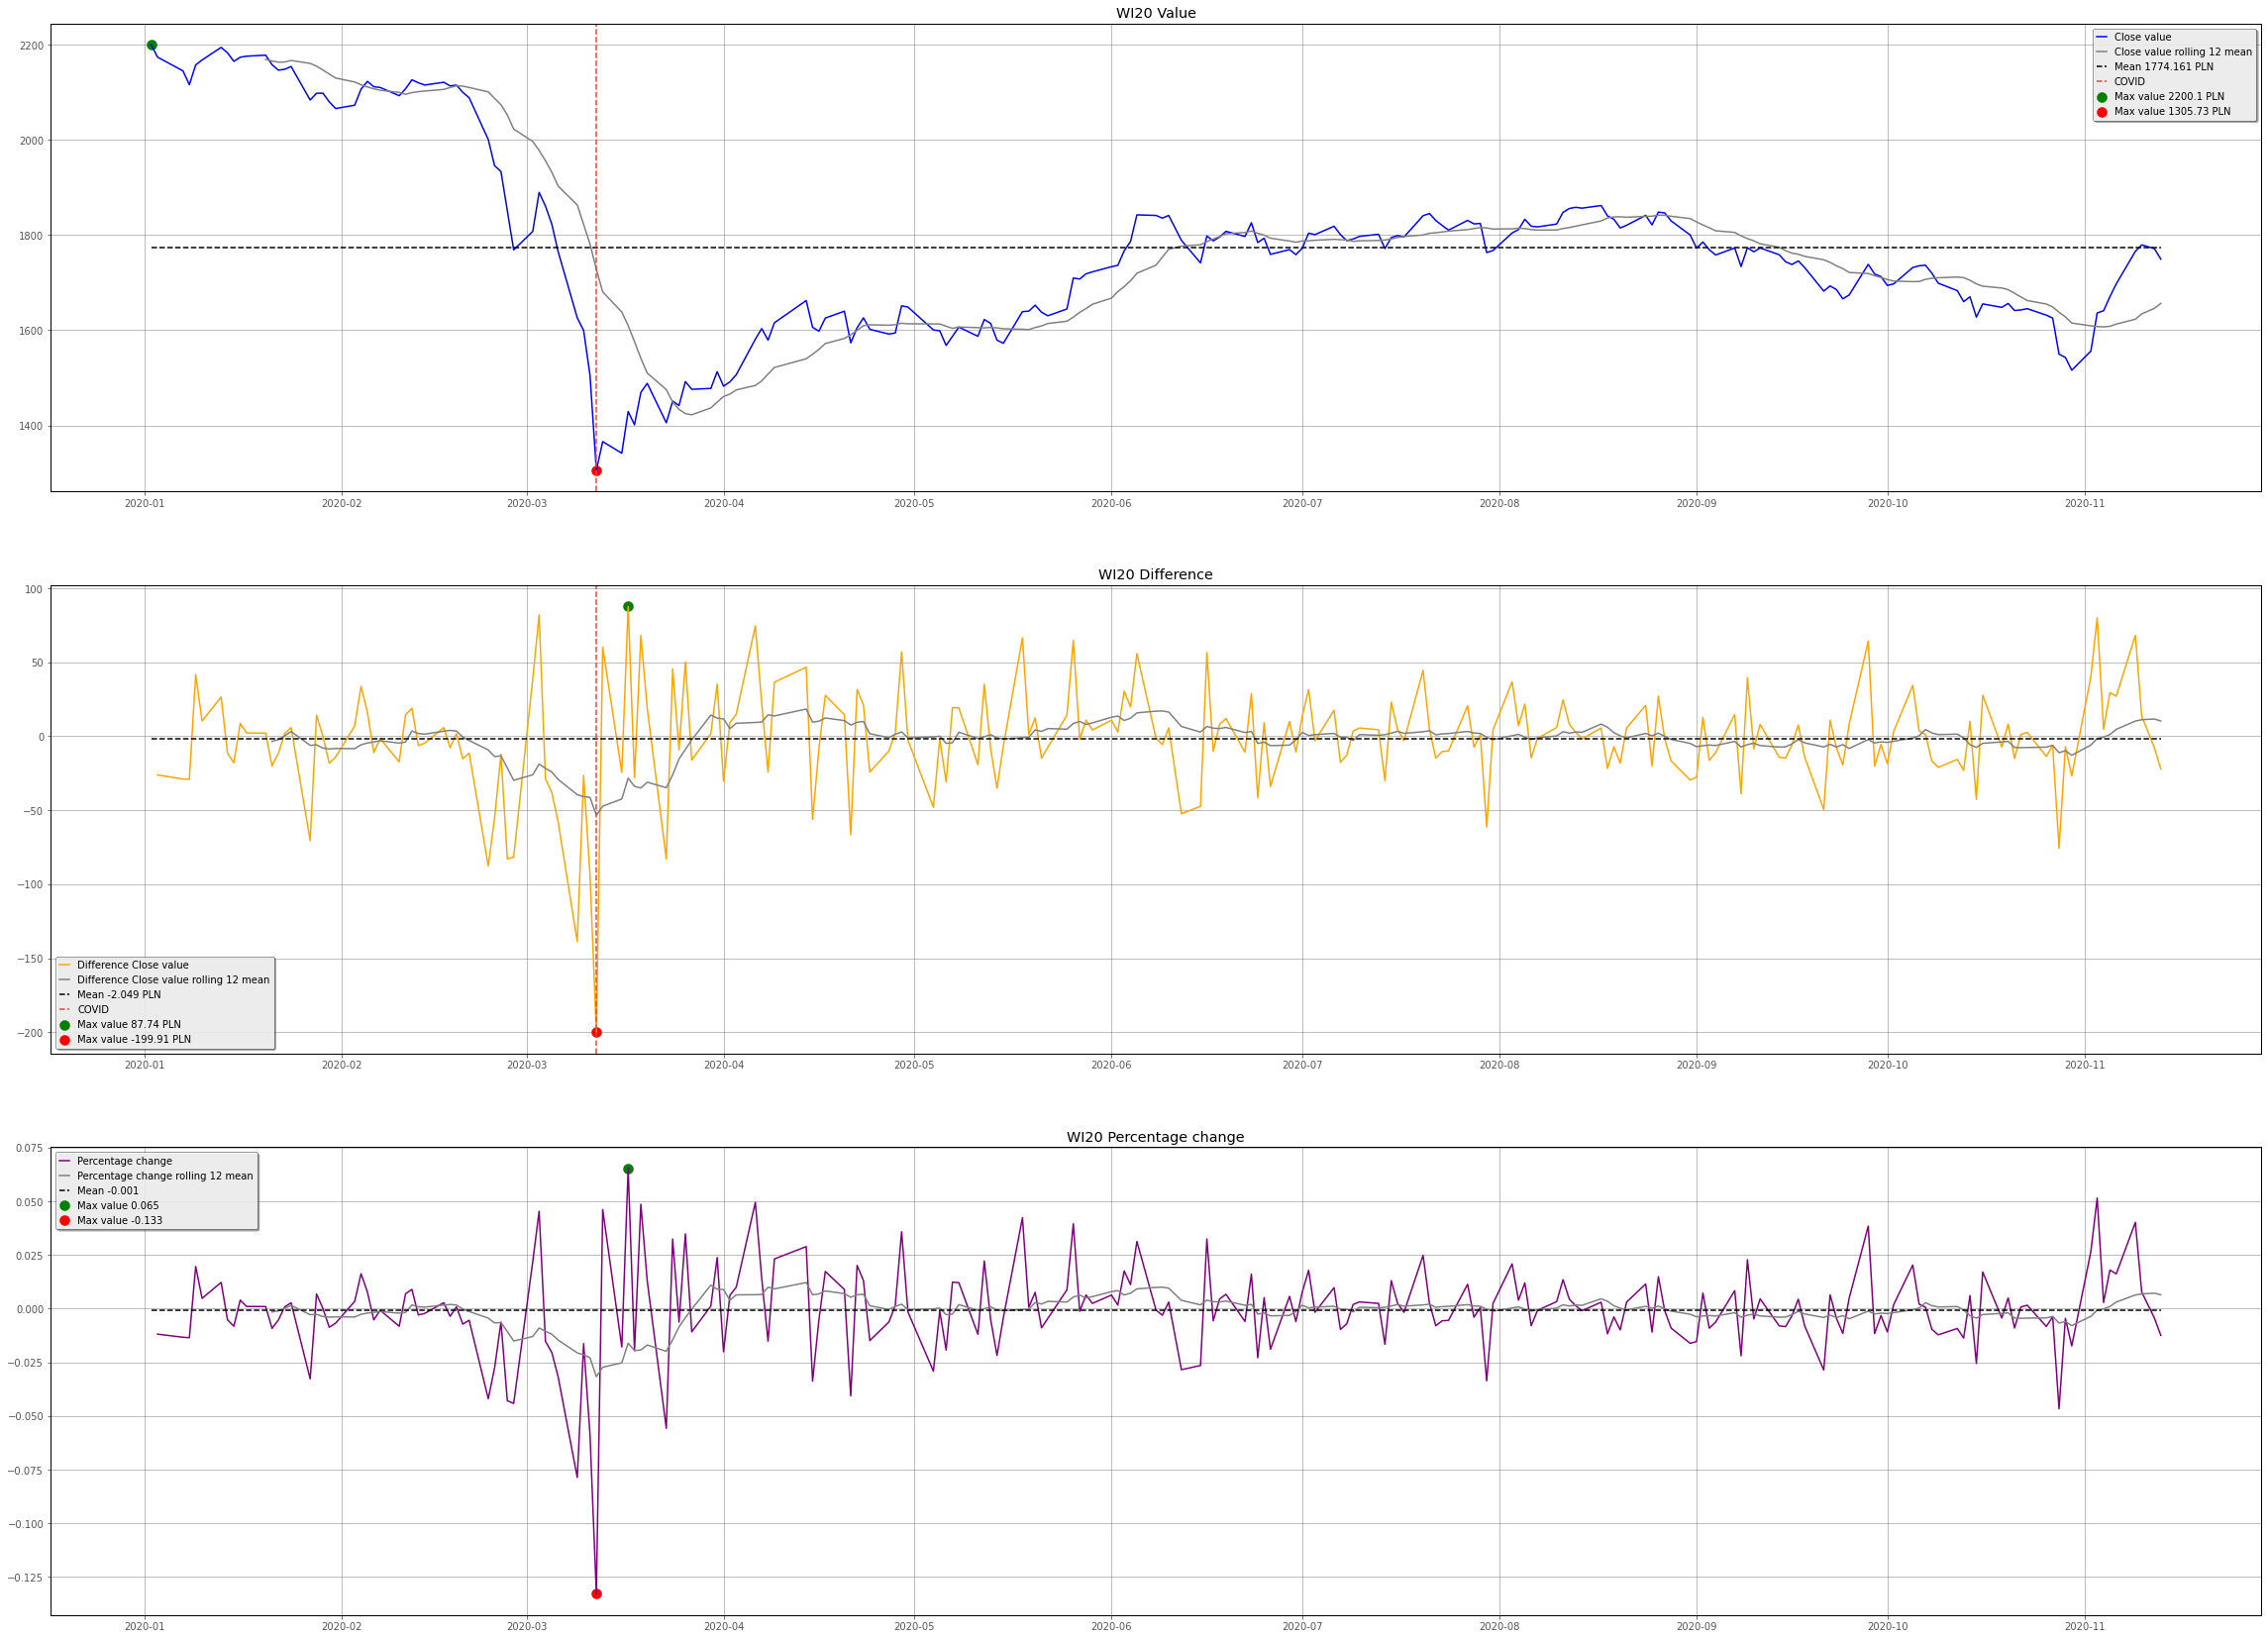

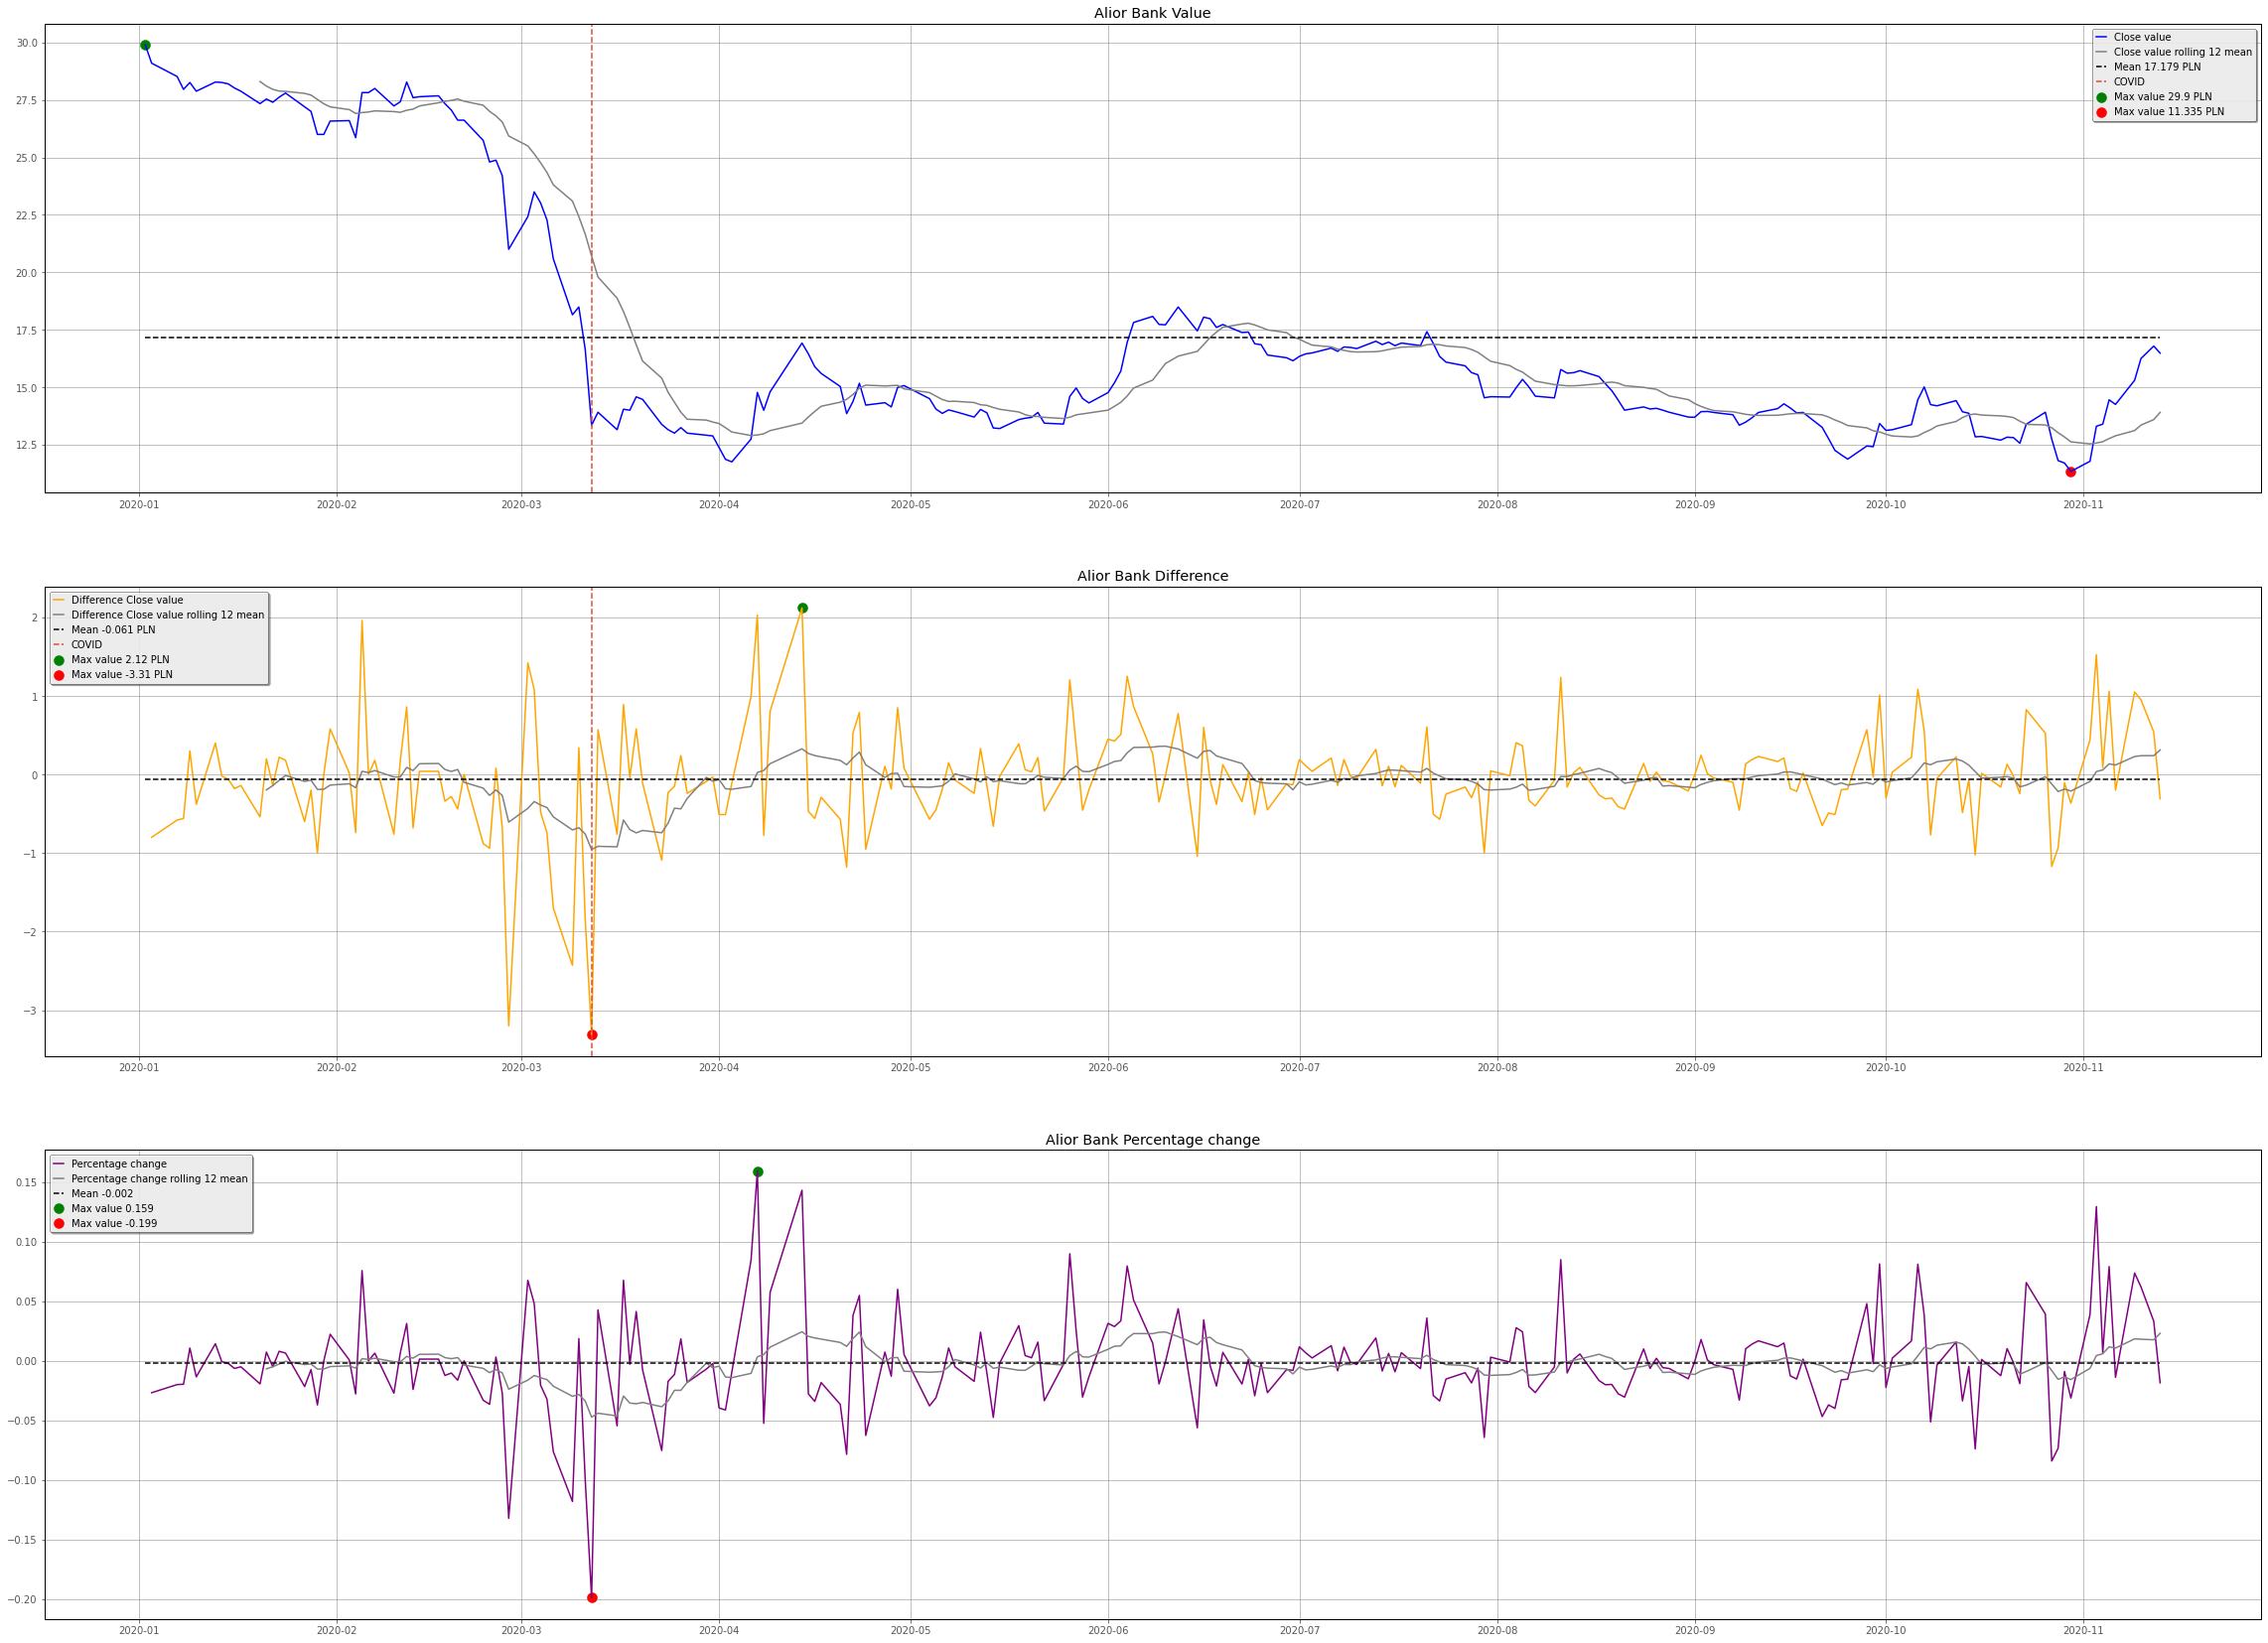

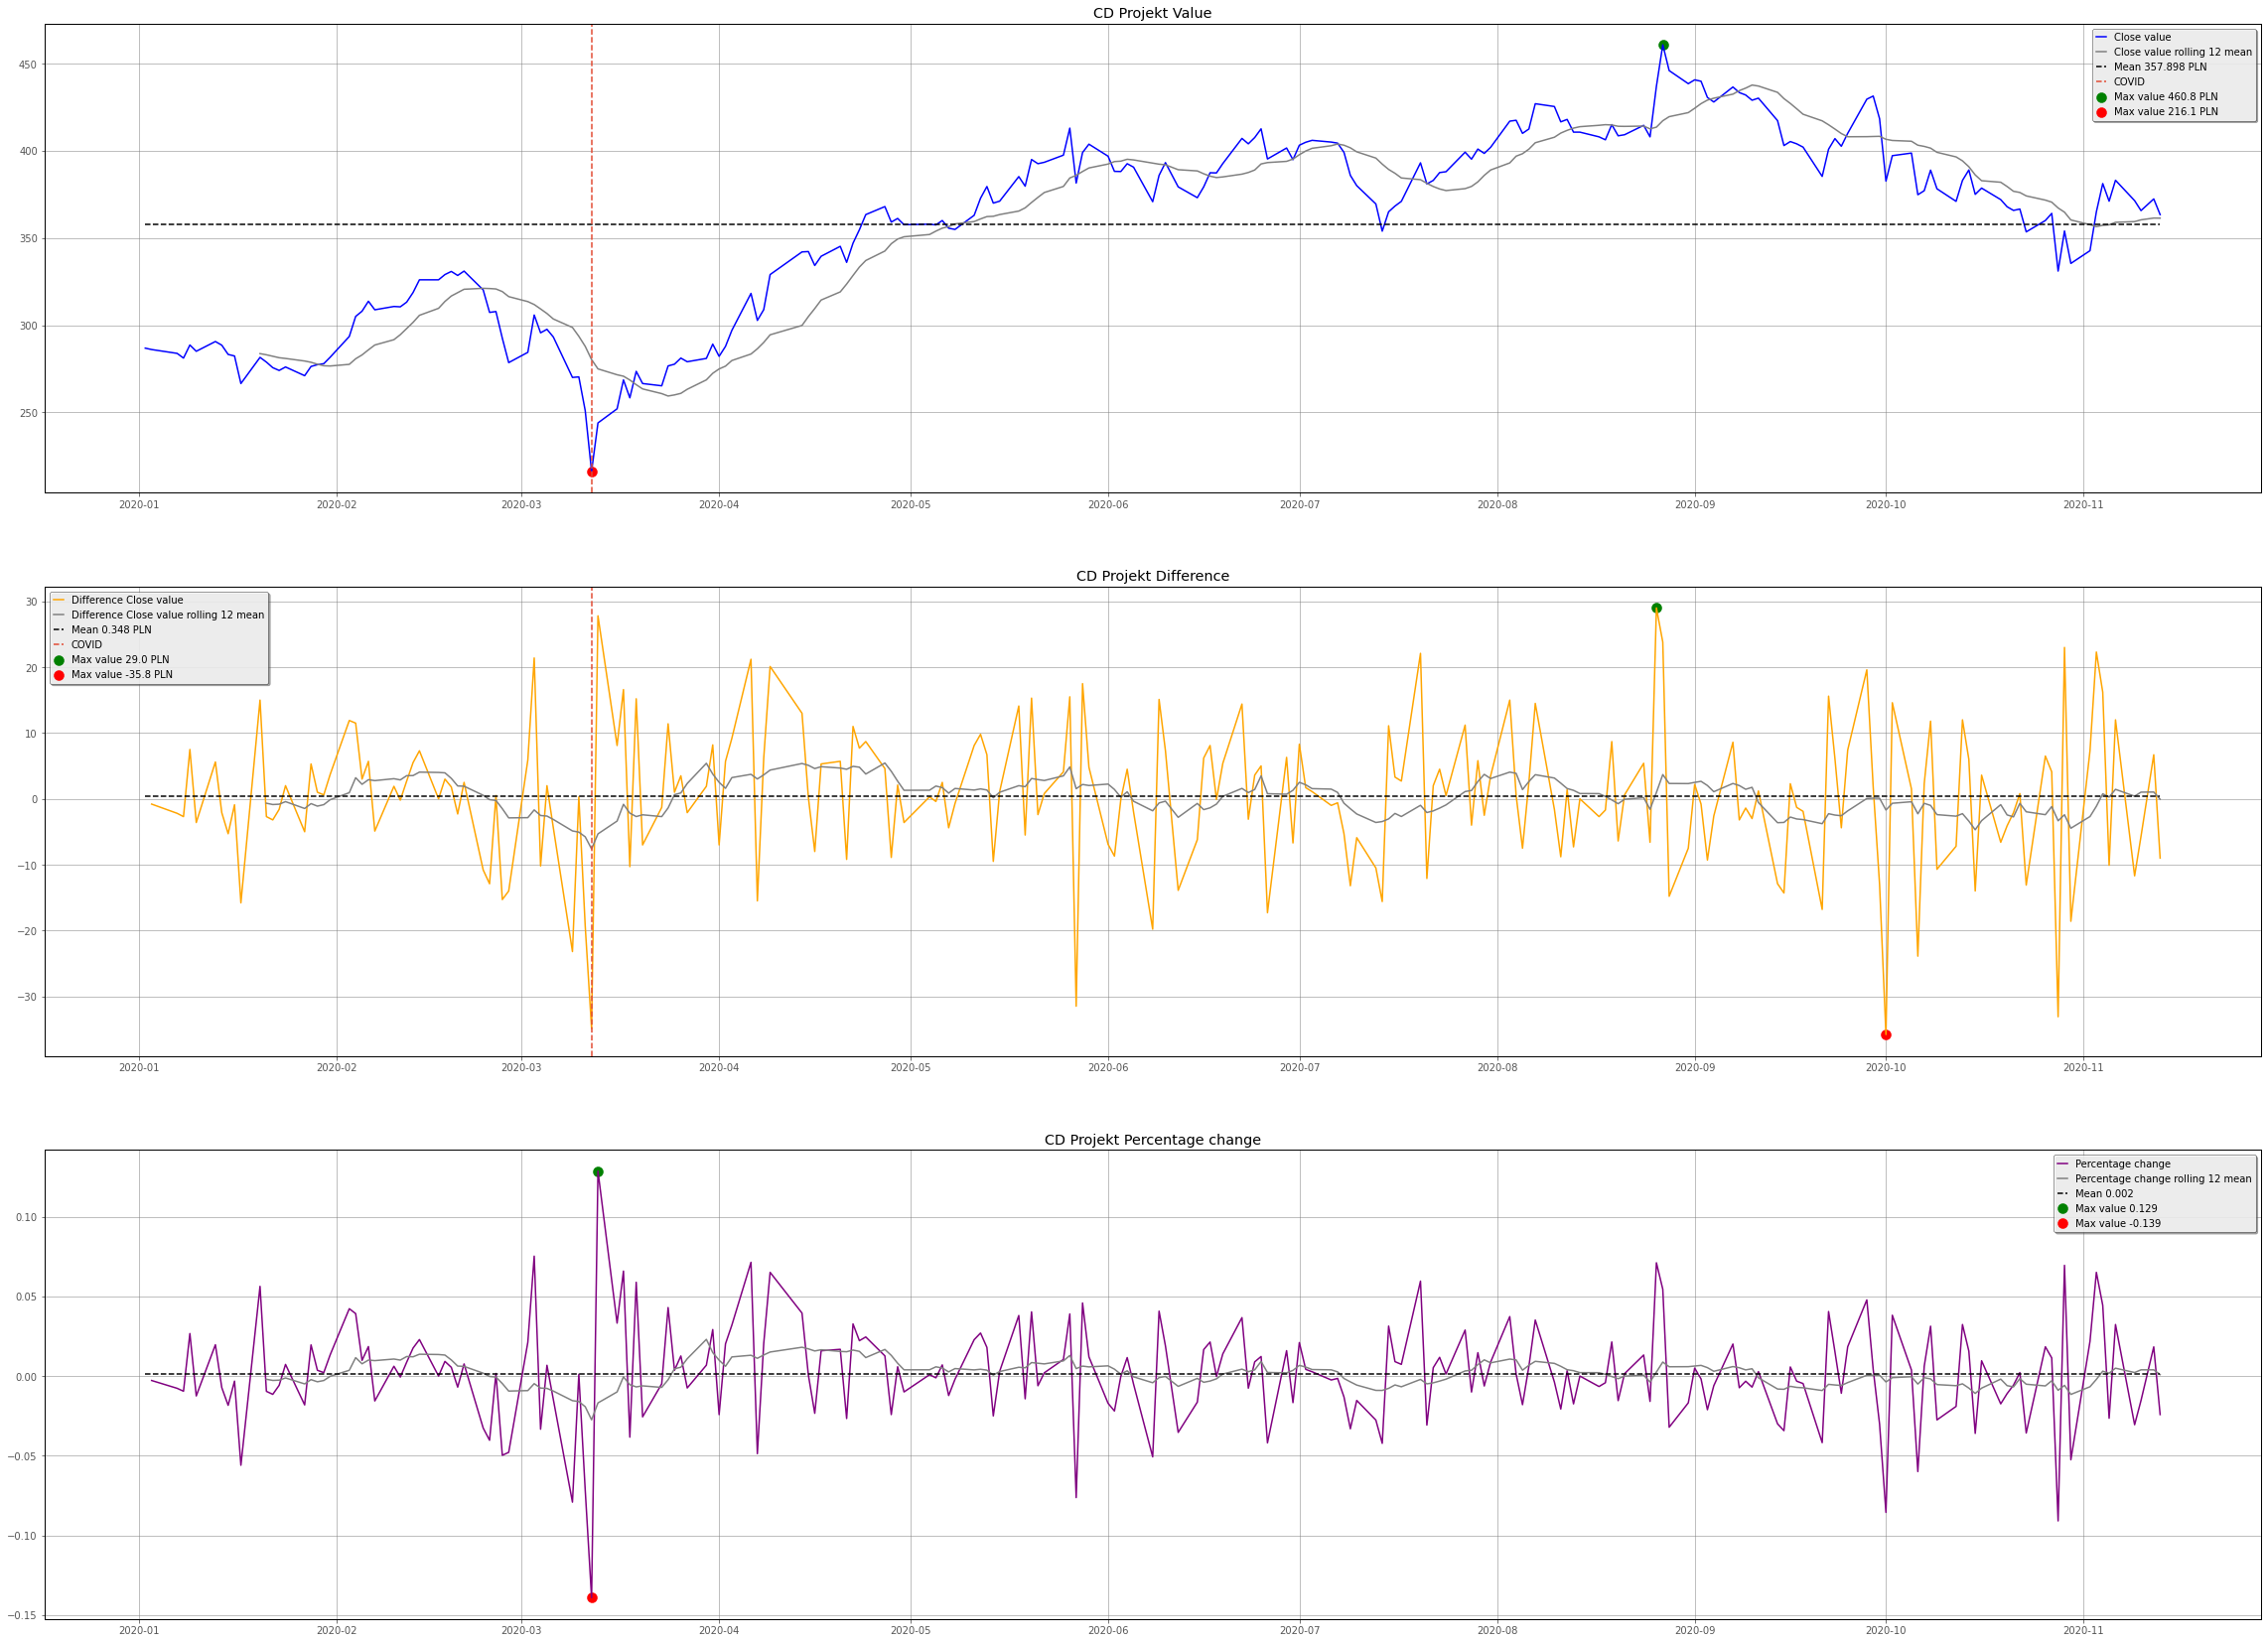

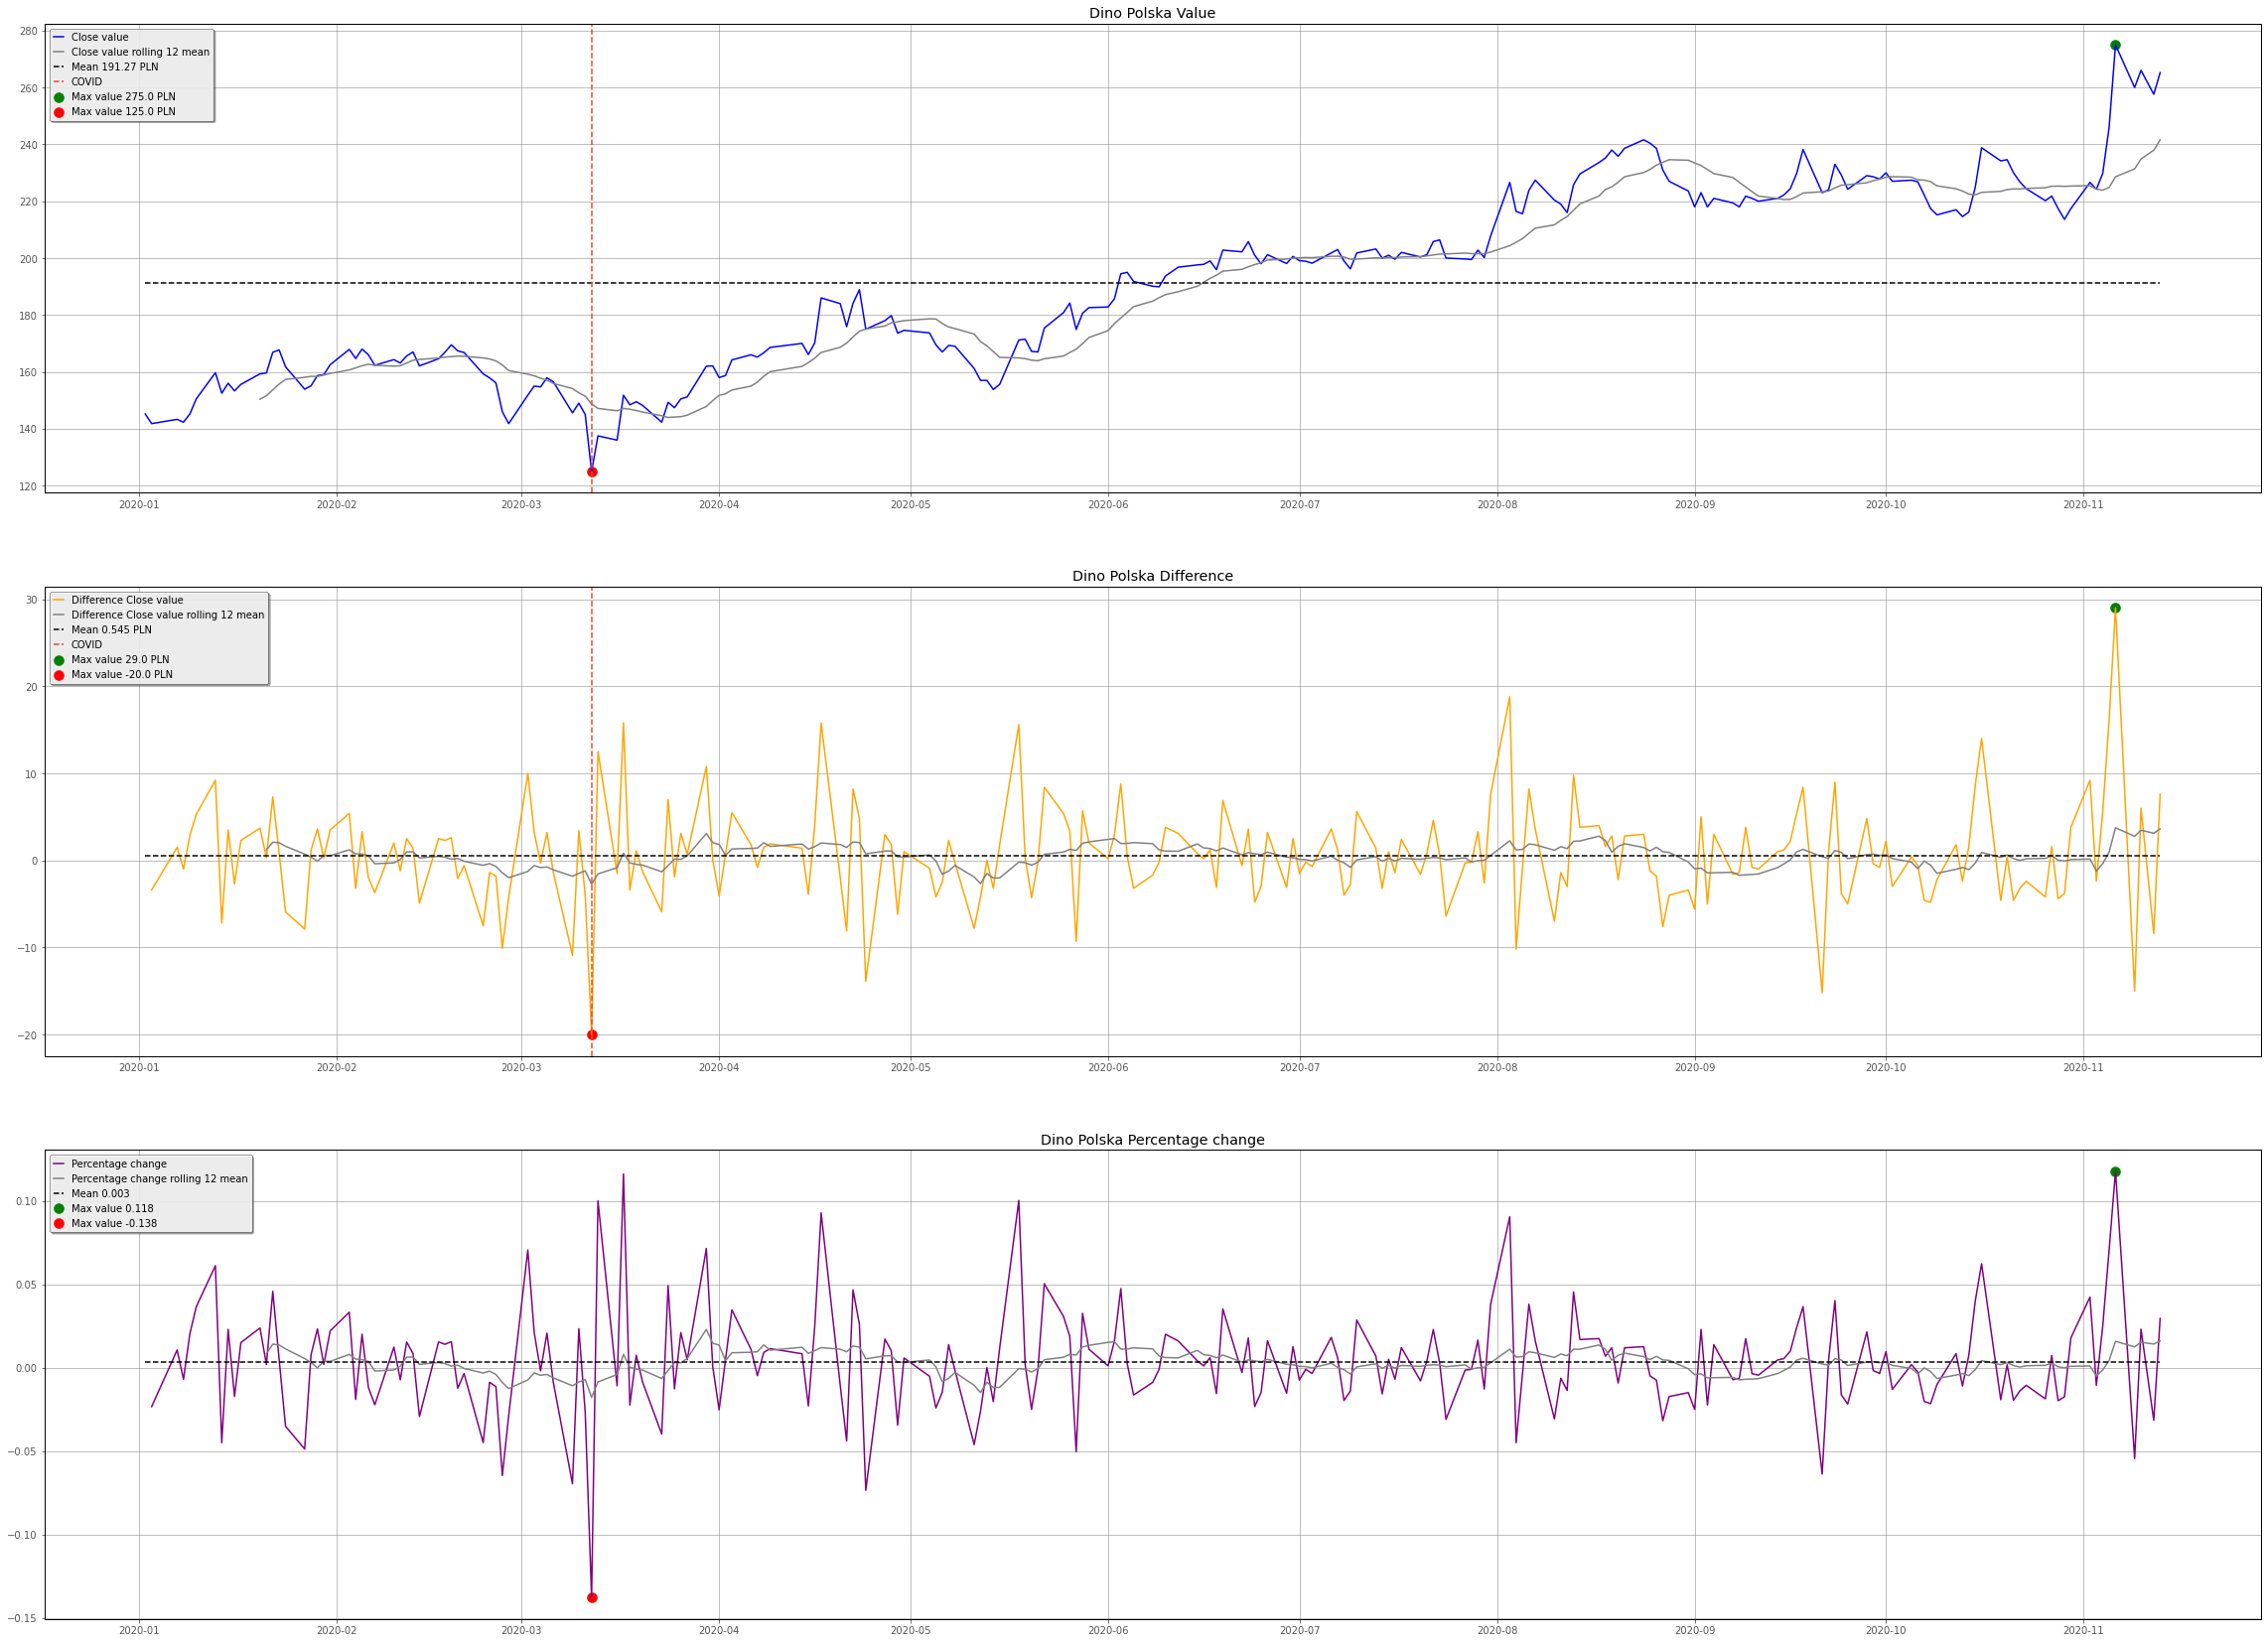

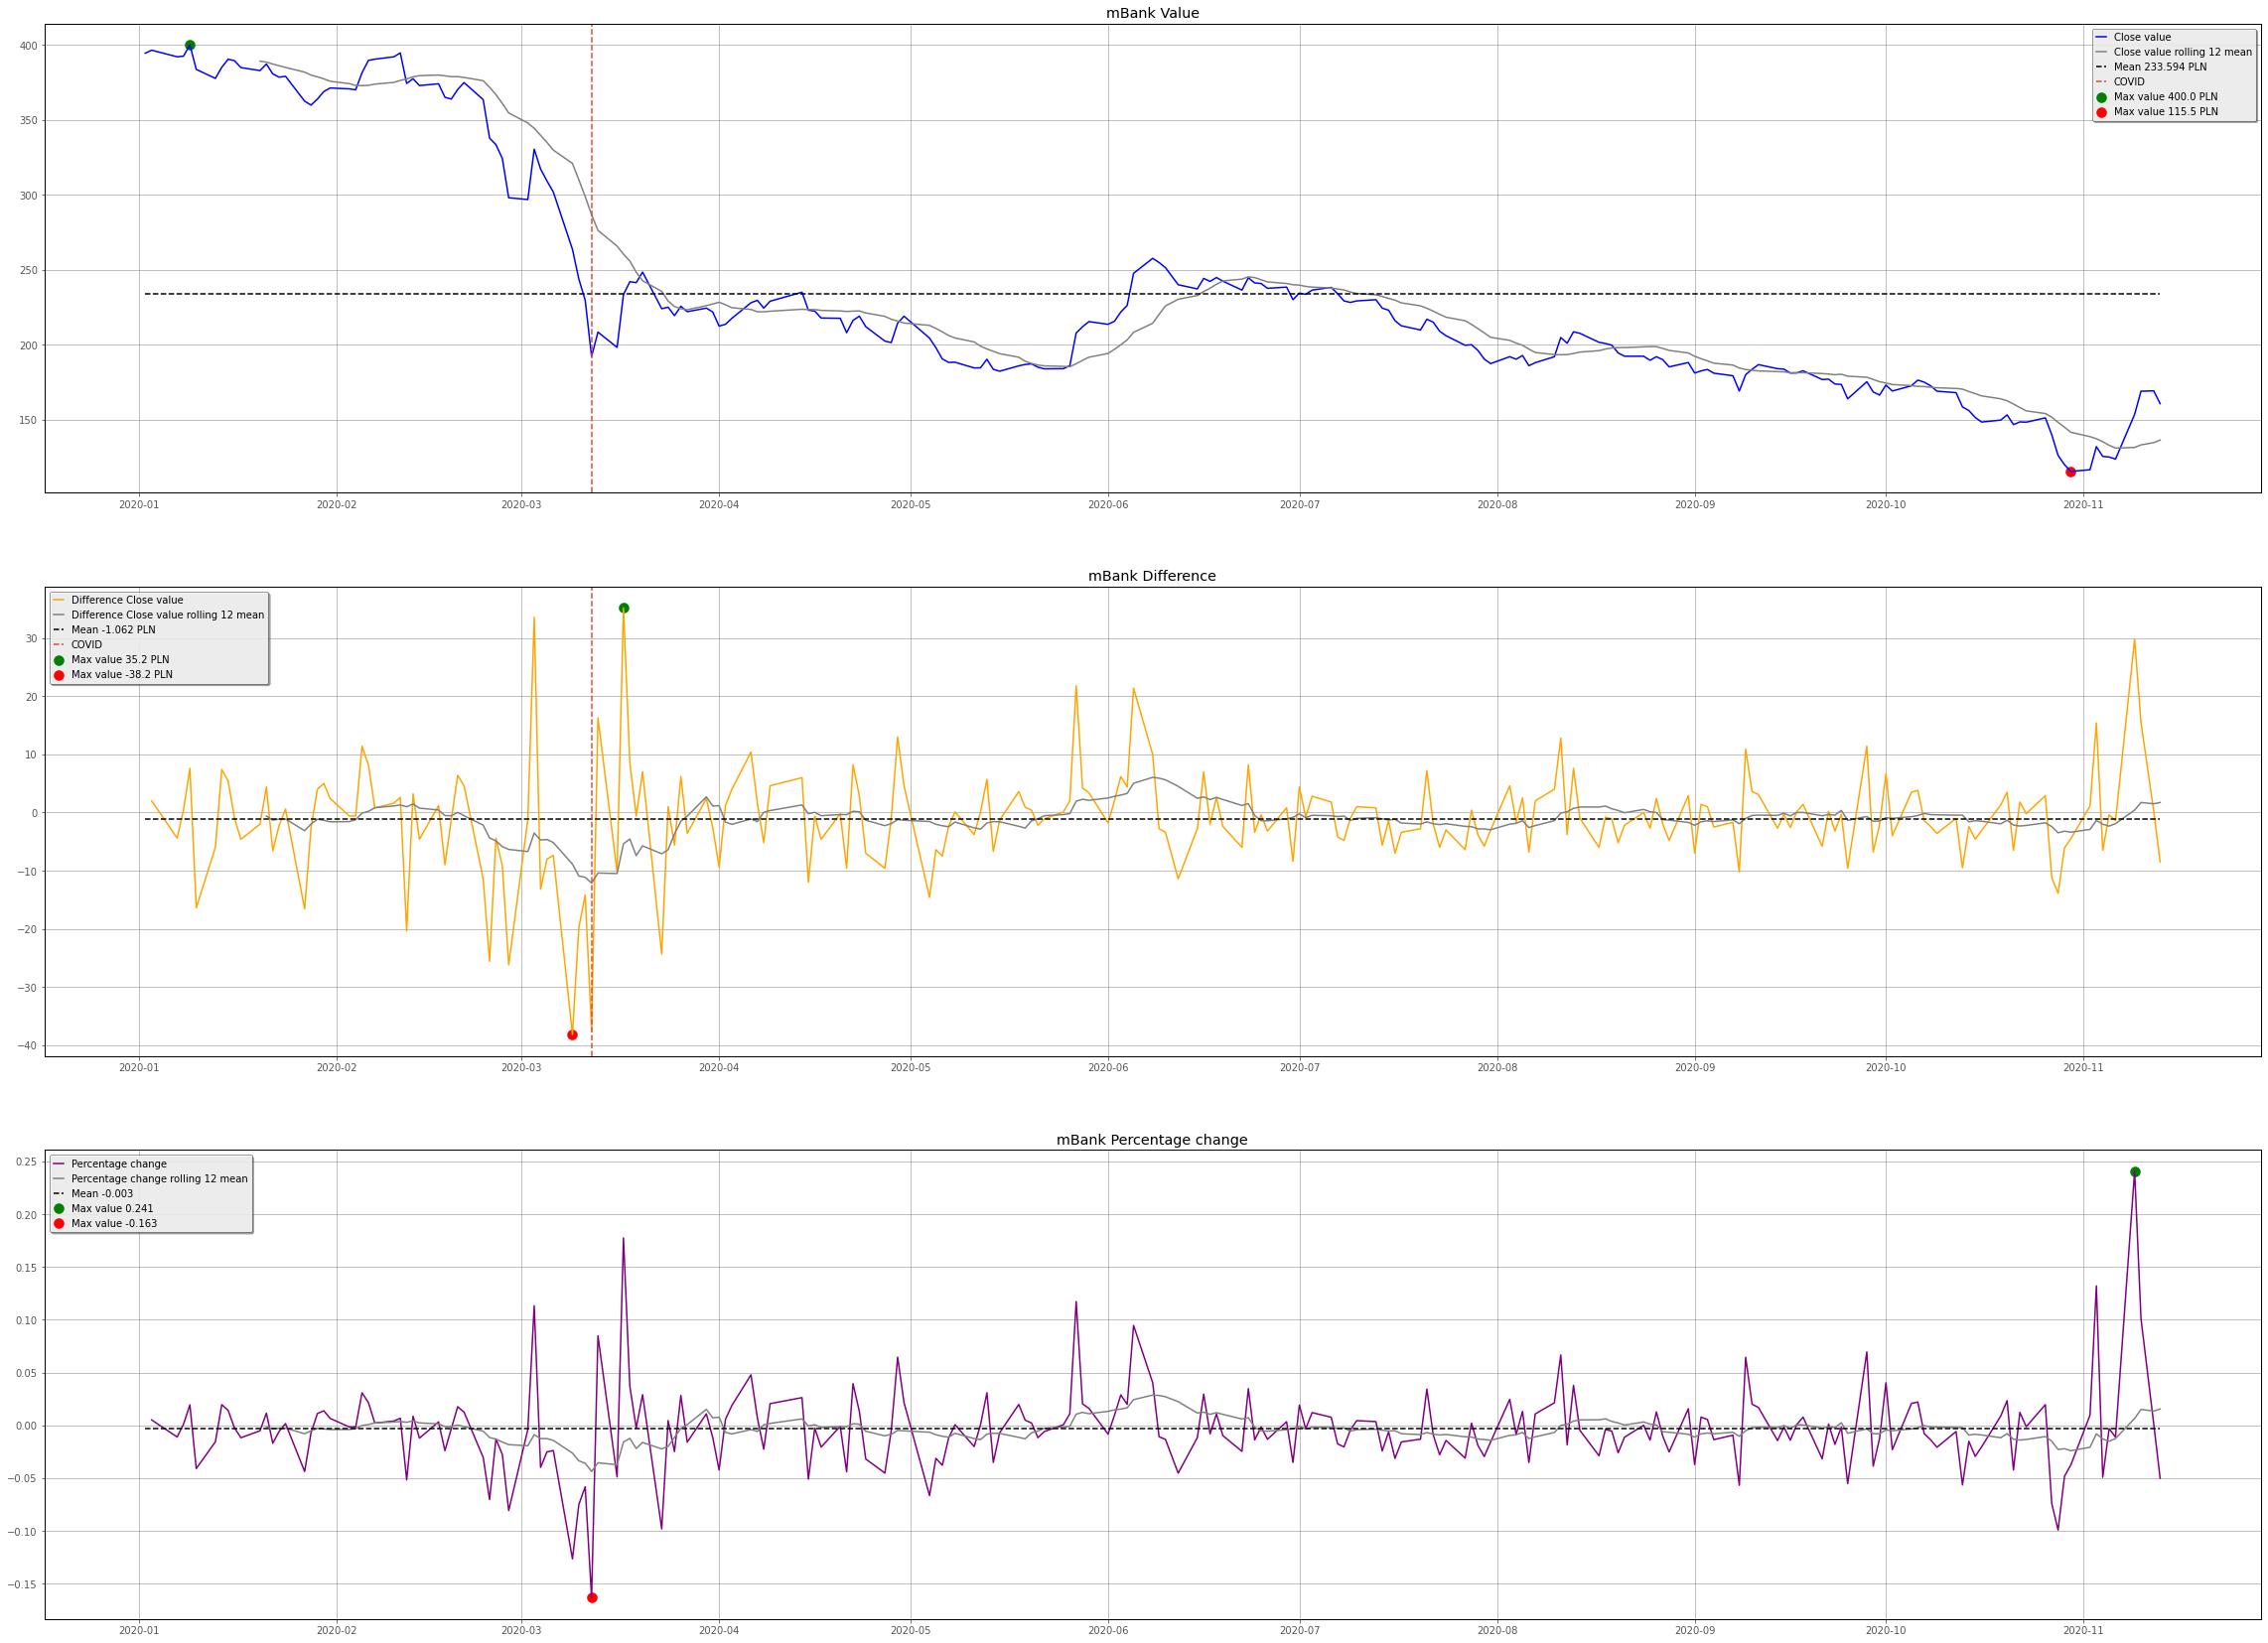

In [13]:
import warnings
warnings.filterwarnings('ignore')
for i in range(df['Stock_name'].nunique()):
  tmp = df[df['Stock_name'] == df['Stock_name'].unique()[i]]
  tmp['Mean'] = tmp['Close'].mean()
  tmp['Mean_diff'] = tmp['Close'].diff().mean()
  tmp['Mean_pct_change'] = tmp['Close'].pct_change().mean()
  plt.figure(figsize=(40,40))
  #Stock value
  plt.subplot(4,1,1)
  plt.plot(tmp['Close'],color = 'blue',label = 'Close value')
  plt.plot(tmp['Close'].rolling(12).mean(),color = 'gray',label = 'Close value rolling 12 mean')
  plt.plot(tmp['Mean'], color = 'black',linestyle='dashed', label = 'Mean ' + str(tmp['Mean'].values[0].round(3)) + " PLN")
  plt.scatter(tmp['Close'].idxmax(), tmp['Close'].max(), color = 'green', s=100, label = 'Max value ' + str(tmp['Close'].max()) + " PLN")
  plt.scatter(tmp['Close'].idxmin(), tmp['Close'].min(), color = 'red', s=100, label = 'Max value ' + str(tmp['Close'].min()) + " PLN")
  plt.axvline(x = tmp['Close'].pct_change().idxmin(), linestyle ='dashed', label = 'COVID')
  plt.title(df['Stock_name'].unique()[i] + ' Value')
  plt.legend()
  plt.grid()
  #Difference value
  plt.subplot(4,1,2)
  plt.plot(tmp['Close'].diff(),color = 'orange',label = 'Difference Close value')
  plt.plot(tmp['Close'].diff().rolling(12).mean(),color = 'gray',label = 'Difference Close value rolling 12 mean')
  plt.plot(tmp['Mean_diff'], color = 'black',linestyle='dashed', label = 'Mean ' + str(tmp['Mean_diff'].values[0].round(3)) + " PLN")
  plt.scatter(tmp['Close'].diff().idxmax(), tmp['Close'].diff().max(), color = 'green', s=100, label = 'Max value ' + str(tmp['Close'].diff().round(3).max()) + " PLN")
  plt.scatter(tmp['Close'].diff().idxmin(), tmp['Close'].diff().min(), color = 'red', s=100, label = 'Max value ' + str(tmp['Close'].diff().round(3).min()) + " PLN")
  plt.axvline(x = tmp['Close'].pct_change().idxmin(), linestyle ='dashed', label = 'COVID')
  plt.title(df['Stock_name'].unique()[i] + ' Difference')
  plt.legend()
  plt.grid()

  #Stock value percentage change
  plt.subplot(4,1,3)
  plt.plot(tmp['Close'].pct_change(), color = 'purple', label = 'Percentage change')
  plt.plot(tmp['Close'].pct_change().rolling(12).mean(), color = 'gray', label = 'Percentage change rolling 12 mean')
  plt.plot(tmp['Mean_pct_change'], color = 'black',linestyle='dashed', label = 'Mean ' + str(tmp['Mean_pct_change'].values[0].round(3)))
  plt.scatter(tmp['Close'].pct_change().idxmax(), tmp['Close'].pct_change().max(), color = 'green', s=100, label = 'Max value ' + str(tmp['Close'].pct_change().round(3).max()))
  plt.scatter(tmp['Close'].pct_change().idxmin(), tmp['Close'].pct_change().min(), color = 'red', s=100, label = 'Max value ' + str(tmp['Close'].pct_change().round(3).min()))
  plt.title(df['Stock_name'].unique()[i] + ' Percentage change')
  plt.grid()
  plt.legend()
  plt.show()


  print(2*"\n")

> # Prepare Data for ARMA model

>>## Prepare Data Frames

In [44]:
#Alior Bank Data Frame
alior = df[df['Stock_name'] == 'Alior Bank'].reset_index()
alior['Percentage_change'] = alior['Close'].pct_change(1).fillna(0)
print(alior['Stock_name'][0])
print(alior.describe())

print("-"*25)

#CD Projekt Data Frame
cdprojekt = df[df['Stock_name'] == 'CD Projekt'].reset_index()
cdprojekt['Percentage_change'] = cdprojekt['Close'].pct_change().fillna(0)
print(cdprojekt['Stock_name'][0])
print(cdprojekt.describe())

print("-"*25)

#Dino Polska Data Frame
dino = df[df['Stock_name'] == 'Dino Polska'].reset_index()
dino['Percentage_change'] = dino['Close'].pct_change().fillna(0)
print(dino['Stock_name'][0])
print(dino.describe())


print("-"*25)

#mBank Data Frame
mbank = df[df['Stock_name'] == 'mBank'].reset_index()
mbank['Percentage_change'] = mbank['Close'].pct_change().fillna(0)
print(mbank['Stock_name'][0])
print(mbank.describe())

Alior Bank
            Close  Percentage_change
count  221.000000         221.000000
mean    17.179005          -0.001855
std      5.158397           0.040889
min     11.335000          -0.198799
25%     13.880000          -0.019802
50%     14.990000          -0.003511
75%     17.715000           0.011871
max     29.900000           0.159341
-------------------------
CD Projekt
            Close  Percentage_change
count  221.000000         221.000000
mean   357.898190           0.001573
std     52.948399           0.031628
min    216.100000          -0.139044
25%    308.900000          -0.015422
50%    371.100000           0.002038
75%    400.900000           0.018388
max    460.800000           0.128644
-------------------------
Dino Polska
            Close  Percentage_change
count  221.000000         221.000000
mean   191.270136           0.003214
std     31.941257           0.031337
min    125.000000          -0.137931
25%    163.100000          -0.014070
50%    195.000000         

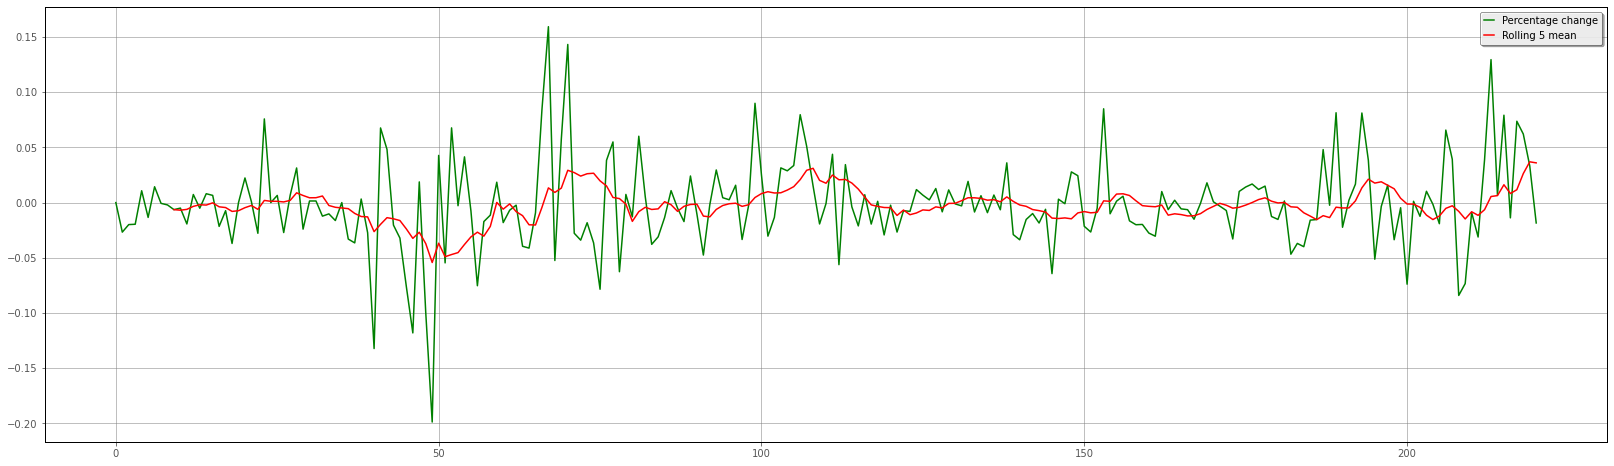

In [46]:
plt.figure(figsize=(28,8))
plt.plot(alior['Percentage_change'], color = 'green', label = 'Percentage change')
plt.plot(alior['Percentage_change'].rolling(10).mean(), color = 'red', label = f'Rolling 5 mean')
plt.grid()
plt.legend()
plt.show()

In [47]:
alior['Percentage_change']

0      0.000000
1     -0.026756
2     -0.019931
3     -0.019635
4      0.010730
         ...   
216   -0.013841
217    0.073684
218    0.062092
219    0.033231
220   -0.018463
Name: Percentage_change, Length: 221, dtype: float64

>## AD Fuller test adn The ACF and PACF

In [48]:
from statsmodels.tsa.stattools import adfuller

In [77]:
def ADF_test(data):
  X = data.fillna(0).values
  result = adfuller(X)
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Critical Values:')
  for key,value in result[4].items():
    print('\t%s: %.3f' % (key, value))
  if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
  else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
  print("-"*50)

In [91]:
def acf_and_pacf(data,n_lags):
  sgt.plot_acf(data.fillna(0), lags= n_lags, alpha = 0.05, zero = False)
  plt.grid()
  plt.title('Autocorrelation function',size = 20)
  plt.show()
  sgt.plot_pacf(data.fillna(0), lags = n_lags, alpha = 0.05, zero = False)
  plt.grid()
  plt.title('Parial Autocorrelation function', size = 20 )
  plt.show()
  print("-"*50)

## Alior

ADF Statistic: -3.5580937337833594
p-value: 0.006614616738478101
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Reject Ho - Time Series is Stationary
--------------------------------------------------


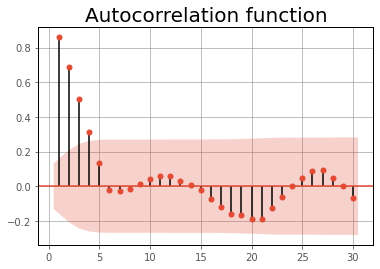

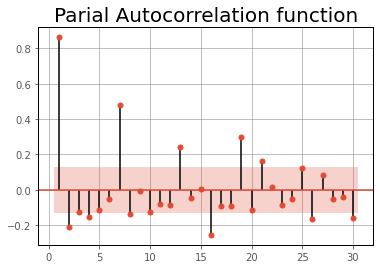

--------------------------------------------------


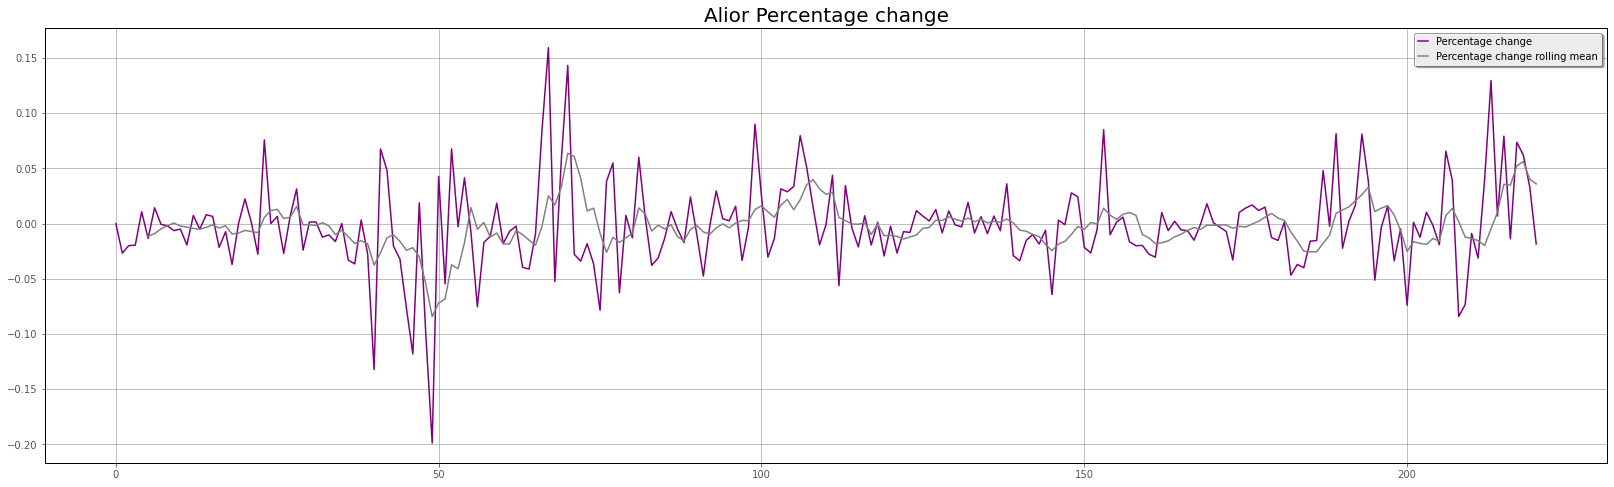

In [99]:
x = alior['Percentage_change'].rolling(6).mean()
ADF_test(x)
acf_and_pacf(x,30)
#Visual
plt.figure(figsize=(28,8))
plt.plot(alior['Percentage_change'], color = 'purple', label = 'Percentage change')
plt.plot(x, color = 'gray', label = 'Percentage change rolling mean')
plt.grid()
plt.legend()
plt.title('Alior Percentage change', size = 20)
plt.show()

In [101]:
x.head(20)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5    -0.011507
6    -0.009115
7    -0.004774
8    -0.001806
9     0.000403
10   -0.002218
11   -0.003205
12   -0.004377
13   -0.005107
14   -0.003415
15   -0.001265
16   -0.004029
17   -0.002026
18   -0.009418
19   -0.008571
Name: Percentage_change, dtype: float64

>>## ARMA(7,4)

In [102]:
from statsmodels.tsa.arima_model import ARMA
model_ar = ARMA(x.iloc[5:], order = (7,4))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:      Percentage_change   No. Observations:                  216
Model:                     ARMA(7, 4)   Log Likelihood                 750.138
Method:                       css-mle   S.D. of innovations              0.007
Date:                Sun, 15 Nov 2020   AIC                          -1474.276
Time:                        18:50:58   BIC                          -1430.397
Sample:                             0   HQIC                         -1456.548
                                                                              
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0016      0.004     -0.455      0.649      -0.008       0.005
ar.L1.Percentage_change     0.6965      0.150      4.631      0.000       0.402       0.991
ar.L2.Percentage_change     0.2032      0.152      1.335      0.183      -0.095       0.501
ar.L3.Percentage_change    -0.5822      0.081     -7.146      0.000      -0.742      -0.423
ar.L4.Percentage_change     0.3448      0.112      3.087      0.002       0.126       0.564
ar.L5.Percentage_change     0.1336      0.097      1.376      0.170      -0.057       0.324
ar.L6.Percentage_change    -0.4096      0.080     -5.088      0.000      -0.567      -0.252
ar.L7.Percentage_change     0.2426      0.075      3.216      0.002       0.095       0.390
ma.L1.Percentage_change     0.3254      0.146      2.231      0.027       0.039       0.611
ma.L2.Percentage_change     0.0019      0.025      0.078      0.938      -0.046       0.050
ma.L3.Percentage_change     0.9726        nan        nan        nan         nan         nan
ma.L4.Percentage_change     0.3624      0.145      2.504      0.013       0.079       0.646
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0574           -0.4141j            1.1356           -0.4406
AR.2           -1.0574           +0.4141j            1.1356            0.4406
AR.3            0.2217           -1.2145j            1.2346           -0.2213
AR.4            0.2217           +1.2145j            1.2346            0.2213
AR.5            1.0290           -0.7430j            1.2692           -0.0995
AR.6            1.0290           +0.7430j            1.2692            0.0995
AR.7            1.3018           -0.0000j            1.3018           -0.0000
MA.1            0.5075           -0.8617j            1.0000           -0.1653
MA.2            0.5075           +0.8617j            1.0000            0.1653
MA.3           -1.0365           -0.0000j            1.0365           -0.5000
MA.4           -2.6621           -0.0000j            2.6621           -0.5000
-----------------------------------------------------------------------------
"""

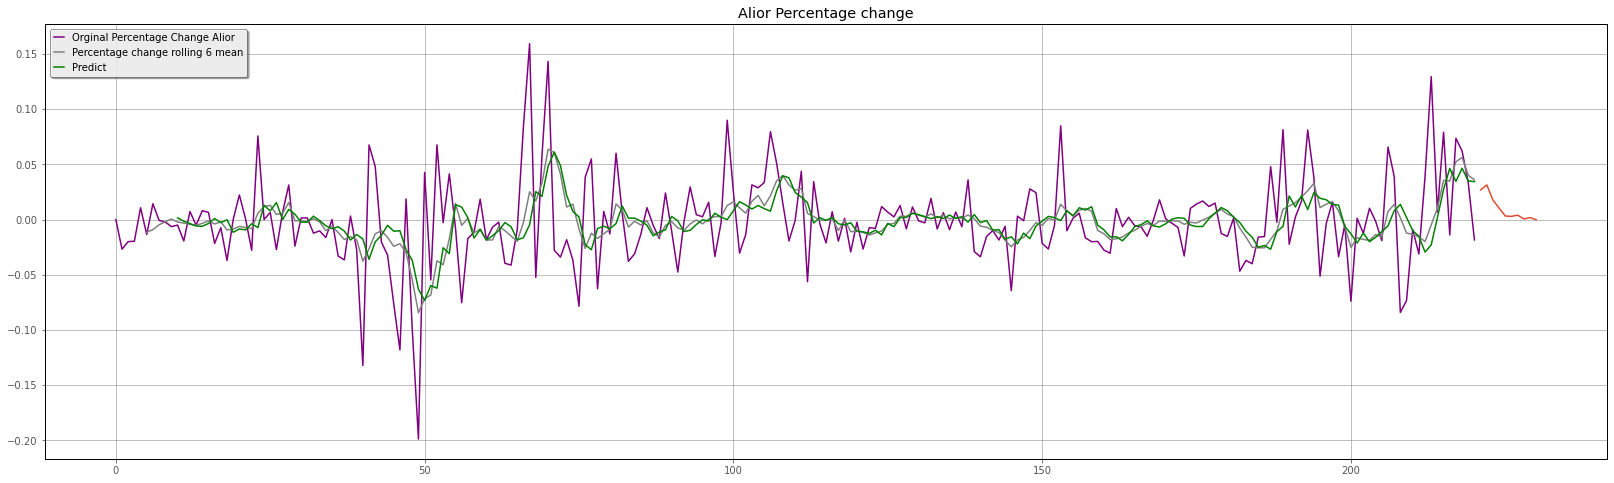

In [110]:
plt.figure(figsize=(28,8))
plt.plot(alior['Percentage_change'], color = 'purple', label = 'Orginal Percentage Change Alior')
plt.plot(x, color = 'gray', label = 'Percentage change rolling 6 mean')
plt.plot(results_ar.predict(), color = 'green', label = 'Predict')
plt.plot(alior.index[-10:]+10,results_ar.forecast(10, alpha = 0.05)[0])
plt.grid()
plt.legend()
plt.title('Alior Percentage change')
plt.show()